# Part 2, The Politeness Dataset

In [105]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, make_scorer, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec

In [83]:
nltk.download('punkt') # this is needed to use NLTK's `word_tokenize` function
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\benja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\benja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [84]:
polite = pd.read_csv('politeness_data.csv')

In [85]:
polite.head

<bound method NDFrame.head of           id                                               text  polite
0       1331  Try to add an `import pycuda` line at the top ...       1
1     196858  Hello, our project has begun to fall a little ...       1
2      25622  Picking up your challenge. You a big fan of sk...       0
3       4161  @Herbert: Still I think your answer is very co...       1
4     526013  Thanks for continuing to look over the article...       1
...      ...                                                ...     ...
4927    6485  You never mentioned how far it is to work? How...       0
4928    3637  Why are the results bad? Can you elaborate on ...       0
4929     765  Thank you, after some experimenting, this seem...       1
4930     991  Why are you using that in the first place? Why...       0
4931    6458  Why on earth would that make for bad chicken s...       0

[4932 rows x 3 columns]>

In [86]:
x=polite.text
y=polite.polite

## Logistic Regression

In [87]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}

In [88]:
pipe_bow = Pipeline([('vec',CountVectorizer()),
                     ('lr', LogisticRegression(C = 1, penalty='l2',solver='saga',max_iter=1000))])

In [89]:
pipe_tfidf = Pipeline([('vec',TfidfVectorizer()), 
                       ('lr', LogisticRegression(C = 1, penalty='l2',solver='saga',max_iter=1000))])
pipe_binary = Pipeline([('vec',CountVectorizer(binary=True)), 
                       ('lr', LogisticRegression(C = 1, penalty='l2',solver='saga',max_iter=1000))])

In [90]:
cv_bow = cross_validate(pipe_bow, x, y, cv=5, scoring = scoring)
cv_tfidf = cross_validate(pipe_tfidf, x, y, cv=5, scoring = scoring)
cv_binary = cross_validate(pipe_binary, x, y, cv=5, scoring = scoring)

In [91]:
lr_models = pd.concat([pd.DataFrame(cv_bow), pd.DataFrame(cv_tfidf), pd.DataFrame(cv_binary)])
lr_models['model'] = np.repeat(['bow','tfidf','binary'], 5)
lr_models.groupby('model').mean()

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score
model,,,,,,
binary,0.326193,0.023488,0.701542,0.703966,0.695873,0.699767
bow,0.627263,0.022621,0.696880,0.699391,0.691004,0.695107
tfidf,0.101053,0.021685,0.710667,0.704289,0.727091,0.715381


For each feature or change in input text processing:
Describe your motivation for including the feature
Discussion of results: Did it improve performance or not? (Either result is fine. It is not necessary to beat logistic regression with unigram features.)

My models are as follows:

- Baseline model, L2 normalized logistic regression with word counts as features
- Tf-idf model, L2 normalized logistic regression with tf-idf weighted word features. My motivation for attempting this is that it will downweight or outright eliminate unimportant, highly frequent words (e.g., 'the'), "biasing" the model estimation process towards rarer, reasonably more informative words.
- Binary model, same as the baseline model except with binary word presence indicators instead of counts. My motivation for attempting this is that it is a simpler model than using counts. For instance, it may be beneficial to indicate whether or word occurs vs. how many times it occurs, because the number of times a word appears may not scale with an increase in odds that the text is polite or impolite. Therefore, this would add some noise to the model estimation process.  
- Other ideas: obtain or make a "politeness" lexicon indicator. Things that I know for certain should be correlated with politeness/impoliteness, e.g., the use of the word `please` or `thank you` bigram or the use of the word `stupid` or a `you suck` bigram.

For a feature-based model of your choice:

List the top 2 most informative features that are mostly strongly positively and negatively associated with politeness. Discuss if you find these surprising and any other comments you might have. You may adapt code provided by the instructor in the Naive Bayes example (notebook here), use another source online, or write your own.

I will give this information for my TF-IDF logistic regression model because it performed the best

In [121]:
pipe_tfidf.fit(x, y)

# Define the most_informative_features function
def most_informative_features(vectorizer, classifier, n=10):
    feature_names = vectorizer.get_feature_names_out()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
    topn_class0 = sorted(zip(-classifier.coef_[0], feature_names))[-n:]
    
    print("Class 1:")
    for coef, feat in reversed(topn_class1):
        print(feat, coef)
        
    print("\nClass 0:")
    for coef, feat in reversed(topn_class0):
        print(feat, coef)


most_informative_features(pipe_tfidf.named_steps['vec'], pipe_tfidf.named_steps['lr'], n=2)

Class 1:
thanks 5.645505067725689
could 3.348128349104262

Class 0:
why 6.488065432838999
homework 2.7116534979864335


That `thanks` is important to politeness is unsurprising. `Could` is also possibly unsurprising, because it can be the start of a polite question.

That `why` is important to impoliteness is interesting because one connotation of this is that `why` questions on StackOverflow usually come from questioning the judgment of the questioner by the answerer. That `homework` is also predictive of impoliteness is interesting because Stackoverflow is a website for people to try answering their own problems first, failing, and then saying why they are stuck. That someone might mention homework in an impolite response might mean they were responding to someone curtly about doing their own homework.

Do an error analysis. Provide a confusion matrix.

In [93]:
pred_y = pipe_tfidf.predict(x)
cm = confusion_matrix(y, pred_y)

print(cm)

[[2106  360]
 [ 339 2127]]


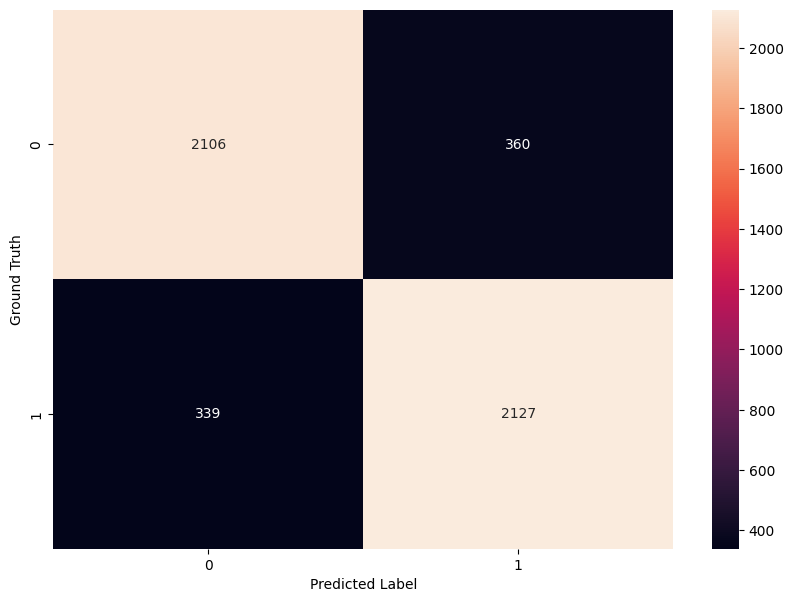

In [94]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('Ground Truth')
plt.show()

The model is about 70% correct, as our accuracy metric indicates. The errors are split approximately 50/50 between false negatives and false positives

Sample multiple examples from both false negatives and false positives. Do you see any patterns in these errors? How might these errors be addressed with different features or if the system could understand something else? (You don’t have to implement these, just speculate.)

In [95]:
def get_misses(outcome, outcome_hat, text_data):
    false_negatives = [i for i, outcome in enumerate(outcome) if ((outcome == 1) & (outcome_hat[i] == 0))]
    false_positives = [i for i, outcome in enumerate(outcome) if ((outcome == 0) & (outcome_hat[i] == 1))]
    top10_positive = ['thanks', 'could', 'hi', 'can', 'for', 'thank', 'help', 'great', 'good', 'would']
    top10_negative = ['why', 'homework', 'really', 'not', 'don', 'who', 'wikipedia', 'what', 'shouldn', 'no']
    neg_in_fn = 0
    pos_in_fn = 0
    neg_in_fp = 0
    pos_in_fp = 0

    print("False Negatives:")
    for i in false_negatives[0:10]:
        print(text_data[i])
        print('Negative Words? ' + str(any(word in text_data[i] for word in top10_negative)))
        if any(word in text_data[i] for word in top10_negative):
            neg_in_fn += 1
        print('Positive Words? ' + str(any(word in text_data[i] for word in top10_positive)))
        if any(word in text_data[i] for word in top10_positive):
            pos_in_fn += 1


    print("\nFalse Positives:")
    for i in false_positives[0:10]:
        print(text_data[i])
        print('Negative Words? ' + str(any(word in text_data[i] for word in top10_negative)))
        print('Positive Words? ' + str(any(word in text_data[i] for word in top10_positive)))
        if any(word in text_data[i] for word in top10_negative):
            neg_in_fp += 1
        if any(word in text_data[i] for word in top10_positive):
            pos_in_fp += 1
    
    print(f'The number of false negative examples with a top 10 informative negative word was {neg_in_fn} out of 10')
    print(f'The number of false negative examples with a top 10 informative positive words was {pos_in_fn} out of 10')
    print(f'The number of false positive examples with a top 10 informative negative words was {neg_in_fp} out of 10')
    print(f'The number of false positive examples with a top 10 informative positive words was {pos_in_fp} out of 10')

get_misses(y, pred_y, x)


False Negatives:
What are you trying to say? You want a Registry Editor?
Negative Words? False
Positive Words? False
Not sure what you are referring to when you say you need an SQL query builder for "Python". Do you mean to say you need an ORM like SQLAlchemy (http://www.sqlalchemy.org/) to connect with databases without having to write SQL statements yourself?
Negative Words? True
Positive Words? True
I confess, no. What's exactly to be read in the docs you are referring to?
Negative Words? True
Positive Words? False
I read the diff upside down or something... Glad someone is keeping an eye on me :) I'm mainly doing stuff over here <url> these days, what are you up to currently? Still concentrating on the Ui Imair?
Negative Words? True
Positive Words? True
What version of bash are you using? Is it 4.x or 3.x?
Negative Words? False
Positive Words? False
At what point in this process did you discover the MBP was unplugged? Is the problem continuing to happen after the MBP is fully recha

In 8 out of 10 false positive examples, there was a positive word that was in the top10 most informative positive words. 
In 5 out of 10 false negative examples, there was a negative word that was in the top10 most informative negative words.

At the same time, both false positive examples and false negative examples also had the presence of informative positive and negative words. Two false positive examples contain the words "can't", which my tokenizer tokenizes partially into the word 'can'. This is a clear example of how preprocessing can affect the downstream prediction task. If I had included 'can't' as its own, full token, this might've helped the model distinguish between someone saying something polite containing 'can' and someone saying something impolite with 'can't' (e.g., "can't you do this?"). 

Another way that the features could be improved is to use larger n-grams. For instance, even if I use the same tokenizer, it could've helped the model if it saw "can" and "'t" as a bigram feature compared to "can" and "'t" as independent and uncorrelated unigram features.

## Neural Network

In this section, you will build and evaluate a feedforward neural network that uses pre-trained static word embeddings (word2vec, GloVe, FastText, etc) as input. To represent the document, you can take the average word embeddings of the input sentence or choose another function. You can choose which activation function to use and other hyperparameters. You will again use 5-fold cross validation on the dataset. There is no need for this model to outperform the logistic regression model you made.

Tasks for section 2.2
Implement a feedforward neural network with static word embeddings as input.


In [96]:
sentences = [nltk.word_tokenize(sentence) for sentence in x]
model = Word2Vec(sentences)
def sentence_to_avg_vector(sentence):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv.key_to_index]
    if not word_vectors:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

polite['text_avg_embedding'] = polite['text'].apply(sentence_to_avg_vector)


In [113]:
nn = MLPClassifier(max_iter=1000, random_state=42)

nn_x = np.stack(polite['text_avg_embedding'].values)
nn_y = polite['polite'].values

cv_nn = cross_validate(nn, nn_x, nn_y, cv=5, scoring = scoring)

In [114]:
nn_model = pd.DataFrame(cv_nn)
nn_model['model'] = np.repeat(['nn'], 5)
all_models = pd.concat([lr_models, nn_model])


In the report, please provide:

Performance scores for this model. Include accuracy as well as precision, recall, and f1-score for the positive (polite) class. This can be an additional row in the table with other performance scores.

In [115]:
all_models.groupby('model').mean()

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score
model,,,,,,
binary,0.326193,0.023488,0.701542,0.703966,0.695873,0.699767
bow,0.627263,0.022621,0.696880,0.699391,0.691004,0.695107
nn,3.998432,0.006944,0.610710,0.614305,0.616010,0.611709
tfidf,0.101053,0.021685,0.710667,0.704289,0.727091,0.715381


The tf-idf model is still the best performing model, logistic regression or otherwise.

Discuss the motivation for any choices you made as far as word embedding types, pretraining dataset, and/or how you represented the document, or if you experimented with multiple of these options.

I used word2vec because it is an easily understandable way to embed words based on their 'positive' contexts. I also estimated embeddings using the polite dataset using the word2vec algorithm because it was easiest. I then represented each sentence/documents as the average embedding of the words it contains because it was straightforward to do so. These motivations are not very virtuous and it shows in the performance of the neural network, although there are also the architectural factors to consider with regards to the performance. I did not experiment with any other embedding or representation options. However, if I were to experiment with different embeddings, I would find a pre-trained embedding obtained from a larger corpus with documents similar to the one in this dataset (code Q&A forum) or another somewhat conversational corpus. For experimenting with representations, perhaps the sum of embeddings would be a better representation than the averages.

Discuss the motivation for any choices you made as far as network architecture (number and dimensions of hidden layers) or hyperparameters (learning rate, number of epochs, etc). Note if you experimented with any of these options.

I don't know why I would choose one architecture and set of hyperparameters over another, so I used default parameters (i.e., one hidden layer with `100 neurons` and the `relu` activation function). This is where hyperparameter tuning comes in so let's try that

In [117]:
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (10,10)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, .001, 0.01, 0.05],
    'learning_rate': ['constant','adaptive'],
}

nn_2 = MLPClassifier(max_iter=300, random_state=42)

nn_grid = GridSearchCV(nn_2, param_grid, cv=5, n_jobs=-1)

# Fit the model to the data
nn_grid.fit(nn_x, nn_y)  # replace X and y with your data

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=300, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.001, 0.01, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (10, 10)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [130]:
x

0       Try to add an `import pycuda` line at the top ...
1       Hello, our project has begun to fall a little ...
2       Picking up your challenge. You a big fan of sk...
3       @Herbert: Still I think your answer is very co...
4       Thanks for continuing to look over the article...
                              ...                        
4927    You never mentioned how far it is to work? How...
4928    Why are the results bad? Can you elaborate on ...
4929    Thank you, after some experimenting, this seem...
4930    Why are you using that in the first place? Why...
4931    Why on earth would that make for bad chicken s...
Name: text, Length: 4932, dtype: object

In [126]:
polite['text_avg_embedding'].values

array([array([ 0.03849498,  0.29648408,  0.06791625, -0.03388536,  0.10964056,
              -0.29727167,  0.05290221,  0.64719325, -0.21412535, -0.07203906,
              -0.05511004, -0.22657014,  0.02251264,  0.25524318, -0.07646068,
              -0.18734314,  0.20749038, -0.24285263, -0.18108326, -0.6431815 ,
               0.14762792,  0.14411975,  0.13561076, -0.05235285, -0.12610151,
              -0.16299121, -0.1402613 , -0.14767891, -0.33188948,  0.25540295,
               0.52841353,  0.0082042 ,  0.16849895, -0.58971983, -0.2134884 ,
               0.6076413 ,  0.13525869, -0.20679975, -0.27537018, -0.5345579 ,
              -0.06494079, -0.31286648, -0.13413282,  0.06689253,  0.3603256 ,
              -0.20546953, -0.18698806, -0.19649453,  0.22384594,  0.05041104,
               0.141752  , -0.20044357, -0.1835096 , -0.06338381, -0.24227352,
               0.07340314,  0.1605139 , -0.03571523, -0.55876875, -0.10154375,
               0.22573948, -0.06322338,  0.12371819,

In [119]:
best_nn_params = nn_grid.best_params_
print("Best parameters:", best_nn_params)

best_nn = MLPClassifier(**best_nn_params, max_iter=300)
best_nn.fit(nn_x, nn_y)  # replace X and y with your data

Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}


MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=300)

In [120]:
pred_nn_y = best_nn.predict(nn_x)
cm = confusion_matrix(nn_y, pred_nn_y)

print(cm)

[[1769  697]
 [1132 1334]]


Even after some minor hyperparameter searching, the neural network still performs poorly with the embeddings I used. This goes to show that the quality of input matters just as much as the model predicting the output. My best guess to improve the input quality is to use a higher quality pre-trained embedding from online, as opposed to a "word2vectorization" of the words in the politeness dataset.